# Ejercicio Práctico - Clase 2 VPC2 - 4co2021

Generar una red convolucional con las siguientes caracteristicas:

*   Conv1: cantidad de filtros=16, tramaño de filtro=3, stride=1, padding="same"
*   Pool1: MaxPooling, tamaño de filtro=2, stride=2
*   Conv2: cantidad de filtros=32, tramaño de filtro=3, stride=1, padding="same"
*   Pool2: MaxPooling, tamaño de filtro=2, stride=2
*   Conv3: cantidad de filtros=64, tramaño de filtro=3, stride=1, padding="same"
*   Pool3: MaxPooling, tamaño de filtro=2, stride=2
*   Conv4: cantidad de filtros=128, tramaño de filtro=3, stride=1, padding="same"
*   Linear1: cantidad de neuronas=100
*   Linear2: capa de salida

Elegir la función de activación que crean mas conveniente.

Ejercicios:

1.   Utilizando el dataset CIFAR10, provisto por PyTorch, entrenar la red sin aplicar data augmentation durante, al menos, 20 epocas. Se produce sobreentrenamiento?
2.   Utilizando el mismo dataset y aplicando las tecnicas de data augmentation que considere necesarias, entrenar nuevamente la red durante, al menos, 20 epocas sin que se produzca sobreentrenamiento hasta alcanzar un accuracy de 80% aproximadamente.
3.   A partir de los resultados obtenidos en los puntos anteriores: ¿Por qué cree que en el segundo caso el ritmo de mejora de la red es mas lento que en el primero?




In [9]:
!nvidia-smi

Sat Jun 11 04:03:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |    951MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.2 MB/s 


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: frog
Label de la imágen 1: truck
Label de la imágen 2: truck
Label de la imágen 3: deer
Label de la imágen 4: automobile
Label de la imágen 5: automobile
Label de la imágen 6: bird
Label de la imágen 7: horse
Label de la imágen 8: ship


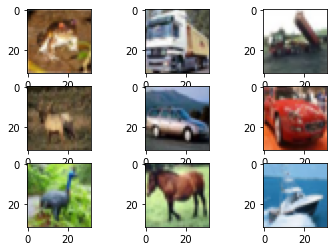

In [2]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}


print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image)
  print("Label de la imágen {}: {}".format(i, idx_to_class[label]))

plt.show()

In [3]:
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(np.shape(train_set[0][0]))

torch.Size([3, 32, 32])


## Train y Valid split

In [6]:
valid_set_size = 5000
train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


## Dataloader

In [7]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

## Red neuronal convolucional

In [8]:
class RedConvCustom(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = RedConvCustom()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
            Linear-8                  [-1, 100]         204,900
            Linear-9                   [-1, 10]           1,010
Total params: 303,350
Trainable params: 303,350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 1.16
Estimated Total Size (MB): 1.46
-------------------------------------------

## Entrenamiento sin data augmentation

In [10]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
conv_model_loss = torch.nn.CrossEntropyLoss()
conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model_optimizer.zero_grad()
    
    output = conv_model(train_data)
    
    loss = conv_model_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model_optimizer.step()

    accuracy = conv_model_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model(valid_data)
    epoch_valid_loss += conv_model_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 1.466100 - Train Accuracy 0.457489 - Valid Loss 1.197225 - Valid Accuracy 0.569000
Epoch: 2/20 - Train loss 1.054356 - Train Accuracy 0.623068 - Valid Loss 1.007800 - Valid Accuracy 0.650200
Epoch: 3/20 - Train loss 0.868686 - Train Accuracy 0.690854 - Valid Loss 0.964768 - Valid Accuracy 0.664200
Epoch: 4/20 - Train loss 0.758240 - Train Accuracy 0.730788 - Valid Loss 0.880052 - Valid Accuracy 0.704200
Epoch: 5/20 - Train loss 0.662237 - Train Accuracy 0.766525 - Valid Loss 0.865224 - Valid Accuracy 0.704000
Epoch: 6/20 - Train loss 0.577781 - Train Accuracy 0.795553 - Valid Loss 0.839319 - Valid Accuracy 0.715200
Epoch: 7/20 - Train loss 0.503603 - Train Accuracy 0.822273 - Valid Loss 0.834221 - Valid Accuracy 0.728800
Epoch: 8/20 - Train loss 0.431807 - Train Accuracy 0.847215 - Valid Loss 0.869971 - Valid Accuracy 0.727600
Epoch: 9/20 - Train loss 0.369673 - Train Accuracy 0.868737 - Valid Loss 0.924778 - Valid Accuracy 0.719800
Epoch: 10/20 - Train loss 0.

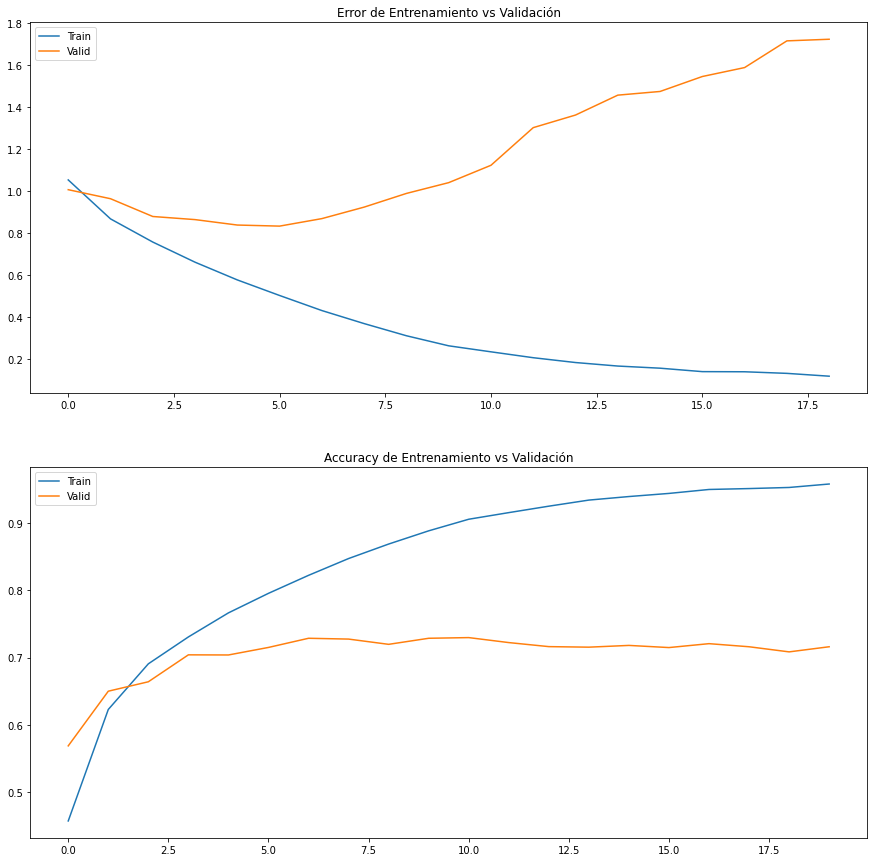

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [13]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = conv_model(test_data)
  test_loss += conv_model_loss(output, test_target).item()
  test_accuracy += conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 1.771524 y una accuracy de 0.711200


## Data augmentation

In [25]:
aud_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ])

aug_train_all_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=aud_data_transforms)
print(np.shape(aug_train_all_set[0][0]))

valid_set_size = 5000
aug_train_set, aug_valid_set = torch.utils.data.random_split(aug_train_all_set, [len(aug_train_all_set) - valid_set_size, valid_set_size])
print("Tamaño del conjunto de entrenamiento: {}".format(len(aug_train_set)))
print("Tamaño del conjunto de validación: {}".format(len(aug_valid_set)))

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

Files already downloaded and verified
torch.Size([3, 32, 32])
Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


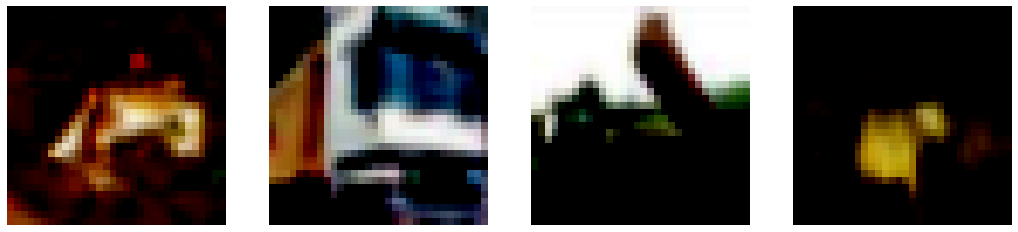

In [26]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_all_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [ ]:
aug_conv_model = RedConvCustom()

if torch.cuda.is_available():
  aug_conv_model = aug_conv_model.to("cuda")

In [ ]:
# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []


**Observacion:**

Se corrio por 120 epochs en total, solo se imprimen los 30 ultimos.

In [31]:

aug_conv_model_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_conv_model_loss = torch.nn.CrossEntropyLoss()
aug_conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  aug_conv_model_accuracy = aug_conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 30


## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_conv_model_optimizer.zero_grad()
    
    aug_output = aug_conv_model(aug_train_data)
    
    aug_loss = aug_conv_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_conv_model_optimizer.step()
    accuracy = aug_conv_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_conv_model(aug_valid_data)
    epoch_valid_loss += aug_conv_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_conv_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/30 - Train loss 0.613331 - Train Accuracy 0.784826 - Valid Loss 0.790832 - Valid Accuracy 0.731489
Epoch: 2/30 - Train loss 0.614528 - Train Accuracy 0.785870 - Valid Loss 0.797638 - Valid Accuracy 0.732882
Epoch: 3/30 - Train loss 0.607750 - Train Accuracy 0.787136 - Valid Loss 0.798756 - Valid Accuracy 0.735868
Epoch: 4/30 - Train loss 0.604076 - Train Accuracy 0.790090 - Valid Loss 0.788743 - Valid Accuracy 0.734275
Epoch: 5/30 - Train loss 0.604642 - Train Accuracy 0.788868 - Valid Loss 0.796675 - Valid Accuracy 0.727309
Epoch: 6/30 - Train loss 0.603734 - Train Accuracy 0.790223 - Valid Loss 0.785309 - Valid Accuracy 0.729299
Epoch: 7/30 - Train loss 0.596395 - Train Accuracy 0.790378 - Valid Loss 0.799493 - Valid Accuracy 0.730295
Epoch: 8/30 - Train loss 0.594385 - Train Accuracy 0.791400 - Valid Loss 0.777158 - Valid Accuracy 0.738256
Epoch: 9/30 - Train loss 0.594748 - Train Accuracy 0.793021 - Valid Loss 0.774363 - Valid Accuracy 0.739053
Epoch: 10/30 - Train loss 0.

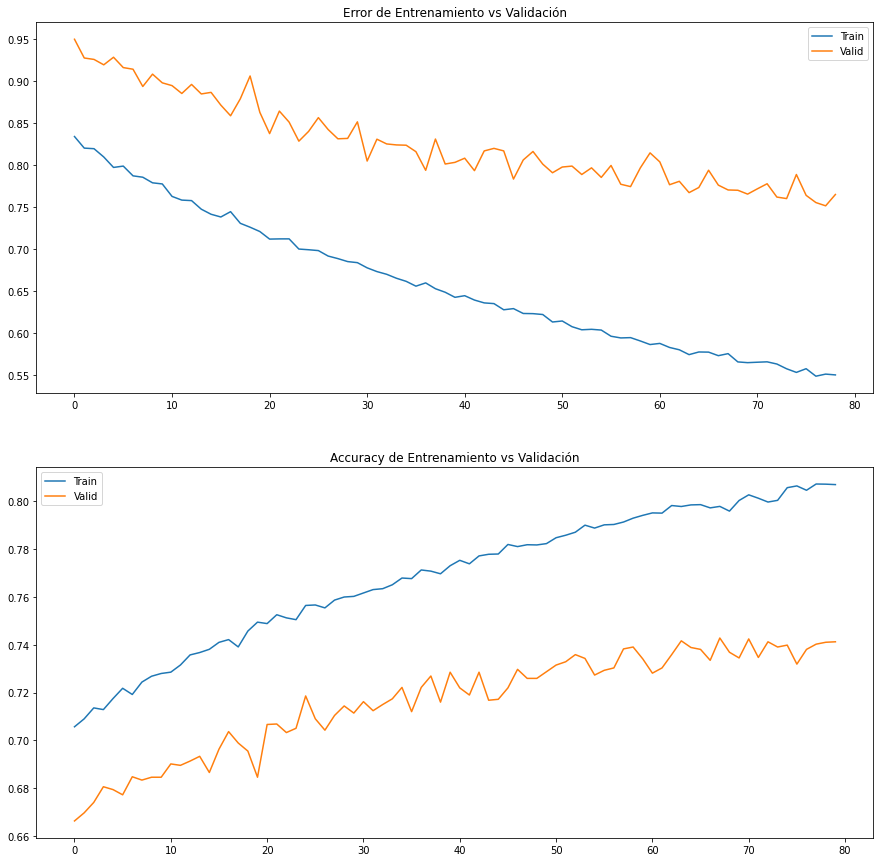

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc)
axs[1].plot(valid_acc)
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [33]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = aug_conv_model(test_data)
  test_loss += aug_conv_model_loss(output, test_target).item()
  test_accuracy += aug_conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.689889 y una accuracy de 0.777500
